# Credit Card Default: Model Tuning and Improving Performance

#### Importing libraries

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

pd.options.mode.chained_assignment = None
%matplotlib inline

#### Loading and preparing the dataset

In [13]:
# Loading the dataset
DATA_DIR = '../data'
FILE_NAME = 'credit_card_default.csv'
data_path = os.path.join(DATA_DIR, FILE_NAME)
ccd = pd.read_csv(data_path, index_col="ID")
ccd.rename(columns=lambda x: x.lower(), inplace=True)
ccd.rename(columns={'default payment next month':'default'}, inplace=True)

# getting the groups of features
bill_amt_features = ['bill_amt'+ str(i) for i in range(1,7)]
pay_amt_features = ['pay_amt'+ str(i) for i in range(1,7)]
numerical_features = ['limit_bal','age'] + bill_amt_features + pay_amt_features

# Creating creating binary features
ccd['male'] = (ccd['sex'] == 1).astype('int')
ccd['grad_school'] = (ccd['education'] == 1).astype('int')
ccd['university'] = (ccd['education'] == 2).astype('int')
ccd['married'] = (ccd['marriage'] == 1).astype('int')

# simplifying pay features 
pay_features= ['pay_' + str(i) for i in range(1,7)]
for x in pay_features:
    ccd.loc[ccd[x] <= 0, x] = 0

# simplifying delayed features
delayed_features = ['delayed_' + str(i) for i in range(1,7)]
for pay, delayed in zip(pay_features, delayed_features):
    ccd[delayed] = (ccd[pay] > 0).astype(int)
    
# creating a new feature: months delayed
ccd['months_delayed'] = ccd[delayed_features].sum(axis=1)

#### Splitting  and standarizing the dataset

In [14]:
numerical_features = numerical_features + ['months_delayed']
binary_features = ['male','married','grad_school','university']
X = ccd[numerical_features + binary_features]
y = ccd['default'].astype(int)

## Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=5/30, random_state=25)

## Standarize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X[numerical_features])
X_train.loc[:, numerical_features] = scaler.transform(X_train[numerical_features])
X_test.loc[:, numerical_features] = scaler.transform(X_test[numerical_features])

## Optimizing more than one parameter

#### Reference model

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
ref_rf = RandomForestClassifier(n_estimators=25,
                                max_features=4,
                                max_depth=4,
                                random_state=61)

ref_rf_scores = cross_val_score(ref_rf, X_train, y_train, scoring='roc_auc', cv=10)

In [24]:
print("Mean AUC for reference model: {:0.4f}".format(ref_rf_scores.mean()))

Mean AUC for reference model: 0.7591


#### Grid Search CV

In [18]:
from sklearn.model_selection import GridSearchCV
param_grid = {"n_estimators":[25,100,200,400],
              "max_features":[4,10,19],
              "max_depth":[4,8,16,20]}

In [19]:
rf = RandomForestClassifier(random_state=17)
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=5,
                           verbose=1,
                           n_jobs=4)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 15.7min
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed: 23.6min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=17, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'n_estimators': [25, 100, 200, 400], 'max_features': [4, 10, 19], 'max_depth': [4, 8, 16, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [8]:
gs_results = pd.Series(grid_search.cv_results_['mean_test_score'], index=grid_search.cv_results_['params'])
gs_results.sort_values(ascending=False)

{'max_depth': 8, 'max_features': 10, 'n_estimators': 400}     0.771326
{'max_depth': 8, 'max_features': 10, 'n_estimators': 200}     0.771129
{'max_depth': 8, 'max_features': 10, 'n_estimators': 100}     0.770636
{'max_depth': 8, 'max_features': 19, 'n_estimators': 200}     0.770251
{'max_depth': 8, 'max_features': 19, 'n_estimators': 400}     0.770065
{'max_depth': 8, 'max_features': 19, 'n_estimators': 100}     0.769861
{'max_depth': 8, 'max_features': 10, 'n_estimators': 25}      0.768982
{'max_depth': 8, 'max_features': 4, 'n_estimators': 400}      0.768858
{'max_depth': 8, 'max_features': 4, 'n_estimators': 200}      0.768732
{'max_depth': 8, 'max_features': 4, 'n_estimators': 100}      0.768362
{'max_depth': 8, 'max_features': 19, 'n_estimators': 25}      0.767242
{'max_depth': 8, 'max_features': 4, 'n_estimators': 25}       0.765414
{'max_depth': 16, 'max_features': 4, 'n_estimators': 400}     0.765067
{'max_depth': 4, 'max_features': 19, 'n_estimators': 200}     0.764648
{'max_

In [26]:
from sklearn.metrics import precision_recall_curve
## Fitting the initial (not tuned) model:
ref_rf.fit(X_train, y_train)

## Getting the probabilites
y_prob_tunned = grid_search.predict_proba(X_test)[:,1]
y_prob_not_tunned = ref_rf.predict_proba(X_test)[:,1]

## Values for plotting the curves
prec_tuned, recall_tuned, _ = precision_recall_curve(y_test, y_prob_tunned)
prec_not_tuned, recall_not_tuned, _ = precision_recall_curve(y_test, y_prob_not_tunned)

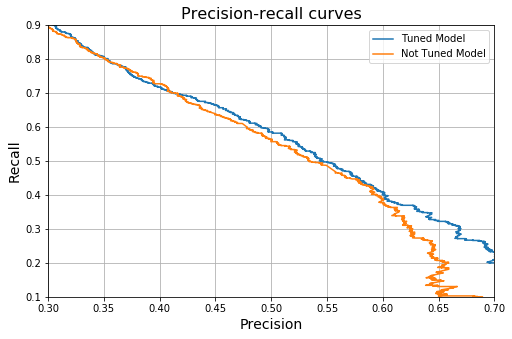

In [30]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(prec_tuned, recall_tuned, label='Tuned Model')
ax.plot(prec_not_tuned, recall_not_tuned, label='Not Tuned Model')
ax.set_title('Precision-recall curves', fontsize=16)
ax.set_xlabel('Precision', fontsize=14)
ax.set_ylabel('Recall', fontsize=14)
ax.set_xlim(0.3,0.7); ax.set_ylim(0.1,0.9)
ax.legend(); ax.grid();